Tabletop gaming has become a billion dollar industry in North America in last 5 years bringing in 1.2 billion dollars in the US and Canada in 2015. With so many new games being developed through major gaming companies, and kickstarted campaigns what are the factors that determine the success of one of these projects?

The purpose of this notebook is to do an exploratory analysis of data from BoardGameGeek.com (BGG) on tabletop games. BGG is an online community for tabletop game enthusiasts where they can rate games that they own or have played. Based on data from over 4000 games our goals for this analysis are:

1. Determine what factors impact users rating of a product
2. Determine what factors are associated with consumers actually buying a product
3. Look at which catagories and mechanics are most common im the highest rated games
4. Create a linear regression model to predict what the user rating will be for a game based on some of the data available.

At the end of this analysis we should have a better idea of which factors to keep in mind when developing a table top game if you are looking for good user experience (high rating) or commercial success (high ownership) and what the most popular themes and mechanics are for these games. We should also have a basic model for predicting what rating a game should expect based on its properties.

In [1]:
# First lets import the packages we will need for our analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 16,4
import warnings
warnings.filterwarnings('ignore')



In [2]:
# Next we will import the data set from Board game Geek
BoardGames = pd.read_csv('BoardGames.csv', encoding='latin-1')

In [3]:
# Lets quickly check to make sure the data looks alright
BoardGames.head()

,rank,bgg_url,game_id,names,min_players,max_players,avg_time,min_time,max_time,year,avg_rating,geek_rating,num_votes,age,mechanic,owned,category,weight
0,1,https://boardgamegeek.com/boardgame/161936/pan...,161936,Pandemic Legacy: Season 1,2,4,60,60,60,2015,8.66905,8.48904,18009,13,"Action Point Allowance System, Co-operative Pl...",29472,"Environmental, Medical",2.8076
1,2,https://boardgamegeek.com/boardgame/182028/thr...,182028,Through the Ages: A New Story of Civilization,2,4,240,180,240,2015,8.72977,8.30744,7309,14,"Action Point Allowance System, Auction/Bidding...",10007,"Card Game, Civilization, Economic",4.3093
2,3,https://boardgamegeek.com/boardgame/12333/twil...,12333,Twilight Struggle,2,2,180,180,180,2005,8.35745,8.22021,27403,13,"Area Control / Area Influence, Campaign / Batt...",37382,"Modern Warfare, Political, Wargame",3.5317
3,4,https://boardgamegeek.com/boardgame/120677/ter...,120677,Terra Mystica,2,5,150,60,150,2012,8.29627,8.15458,24267,12,"Route/Network Building, Variable Phase Order, ...",27948,"Civilization, Economic, Fantasy, Territory Bui...",3.9387
4,5,https://boardgamegeek.com/boardgame/174430/glo...,174430,Gloomhaven,1,4,150,90,150,2017,9.08970,8.15151,3978,12,"Action / Movement Programming, Campaign / Batt...",6057,"Adventure, Economic, Exploration, Fantasy, Fig...",3.7028


Now we will clean up the data a bit starting with the column names and then by removing any columns we won't need to our analysis.

In [4]:
# Lets update a few of our column names for clarity; weight is actually the complexity of the game.
BoardGames.columns = ['rank', 'bgg_url', 'game_id', 'names', 'min_players', 'max_players',
       'avg_time', 'min_time', 'max_time', 'year', 'avg_rating', 'geek_rating',
       'num_votes', 'age', 'mechanic', 'owned', 'category', 'complexity']

In [5]:
# Check to make sure new column names are correct
BoardGames.head()

,rank,bgg_url,game_id,names,min_players,max_players,avg_time,min_time,max_time,year,avg_rating,geek_rating,num_votes,age,mechanic,owned,category,complexity
0,1,https://boardgamegeek.com/boardgame/161936/pan...,161936,Pandemic Legacy: Season 1,2,4,60,60,60,2015,8.66905,8.48904,18009,13,"Action Point Allowance System, Co-operative Pl...",29472,"Environmental, Medical",2.8076
1,2,https://boardgamegeek.com/boardgame/182028/thr...,182028,Through the Ages: A New Story of Civilization,2,4,240,180,240,2015,8.72977,8.30744,7309,14,"Action Point Allowance System, Auction/Bidding...",10007,"Card Game, Civilization, Economic",4.3093
2,3,https://boardgamegeek.com/boardgame/12333/twil...,12333,Twilight Struggle,2,2,180,180,180,2005,8.35745,8.22021,27403,13,"Area Control / Area Influence, Campaign / Batt...",37382,"Modern Warfare, Political, Wargame",3.5317
3,4,https://boardgamegeek.com/boardgame/120677/ter...,120677,Terra Mystica,2,5,150,60,150,2012,8.29627,8.15458,24267,12,"Route/Network Building, Variable Phase Order, ...",27948,"Civilization, Economic, Fantasy, Territory Bui...",3.9387
4,5,https://boardgamegeek.com/boardgame/174430/glo...,174430,Gloomhaven,1,4,150,90,150,2017,9.08970,8.15151,3978,12,"Action / Movement Programming, Campaign / Batt...",6057,"Adventure, Economic, Exploration, Fantasy, Fig...",3.7028


In [6]:
# Eliminate games with less than 50 votes
BoardGames = BoardGames[BoardGames.num_votes > 50]
# Eliminate games made before 1990
BoardGames = BoardGames[BoardGames.year > 1989]
# Eliminate board games with a listed average time less then 10 minutes and more then 5 hours (300 minutes)
BoardGames = BoardGames[(BoardGames.avg_time > 10) & (BoardGames.avg_time < 300)]   
# Eliminate games with an average number of players greater than 10 just to look at table top games and remove 
# larger party games.
BoardGames['avg_players'] = ((BoardGames['min_players']) + (BoardGames['max_players']))/2
BoardGames = BoardGames[BoardGames.avg_players < 11]
# a small subset of games with extremely high ownership will create issues for our visualizations later on
BoardGames = BoardGames[BoardGames.owned < 40000]
# Rounding the complexity to 1 decimal place and make sure it is greater than 0
BoardGames['complexity'] = round(BoardGames.complexity,1)
BoardGames = BoardGames[BoardGames.complexity > 0]
# The geek_rating is a proprietary rating that is given by Board Game Geek. For the purposes of our 
# analysis we will only be using the unmodified user ratings.
del BoardGames['geek_rating']
# We also won't be needing the url or game_id
del BoardGames['bgg_url']
del BoardGames['game_id']
# now we will reset our indices under a new dataframe so we can easily use slices for our analysis
BoardGamesClean = BoardGames.reset_index(drop=True)


In [7]:
# now lets look at the statistics on our data set and make sure everything looks okay.
BoardGamesClean.describe()

,rank,min_players,max_players,avg_time,min_time,max_time,year,avg_rating,num_votes,age,owned,complexity,avg_players
count,4064.000000,4064.000000,4064.000000,4064.000000,4064.000000,4064.000000,4064.000000,4064.000000,4064.000000,4064.000000,4064.000000,4064.000000,4064.000000
mean,2411.531250,2.040600,4.596211,70.931594,61.618110,70.476378,2008.845472,6.919053,1649.772638,10.380906,2452.450787,2.289936,3.318406
std,1443.158927,0.627984,2.000762,53.429376,49.416256,53.646948,6.396008,0.553772,3161.137836,3.175650,4186.776581,0.735630,1.146374
min,1.000000,0.000000,0.000000,12.000000,0.000000,0.000000,1990.000000,5.783210,52.000000,0.000000,12.000000,1.000000,0.000000
25%,1144.750000,2.000000,4.000000,30.000000,30.000000,30.000000,2005.000000,6.488665,250.000000,8.000000,521.000000,1.700000,2.500000
50%,2374.000000,2.000000,4.000000,60.000000,45.000000,60.000000,2011.000000,6.872335,564.000000,10.000000,1044.000000,2.200000,3.000000
75%,3650.250000,2.000000,6.000000,90.000000,75.000000,90.000000,2014.000000,7.286377,1470.250000,12.000000,2401.500000,2.800000,4.000000
max,4999.000000,6.000000,18.000000,290.000000,270.000000,290.000000,2018.000000,9.331670,30855.000000,42.000000,39970.000000,4.600000,10.500000


Now that we have our data cleaned the way we'd like we can being looking at our first objective:

Which factors have the greatest impact on users ratings of a game?

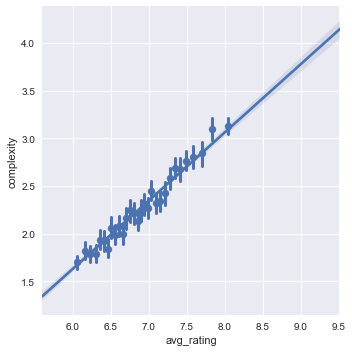

In [8]:
# First lets look at complexity versus the average rating
RatingVis1 = sns.lmplot(data=BoardGamesClean,x='avg_rating',y='complexity',x_bins=30,)

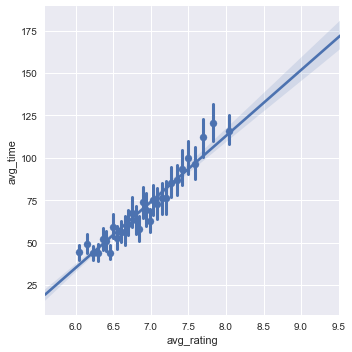

In [9]:
# Lets plot the rating versus the average time spent playing

RatingVis2 = sns.lmplot(data=BoardGamesClean,x='avg_rating',y='avg_time',x_bins=30,)


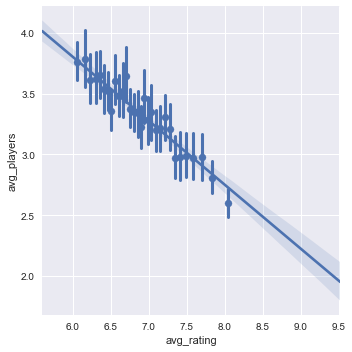

In [10]:
# We can also look at the rating versus the average number of players
RatingVis3 = sns.lmplot(data=BoardGamesClean,x='avg_rating',y='avg_players',x_bins=30,)

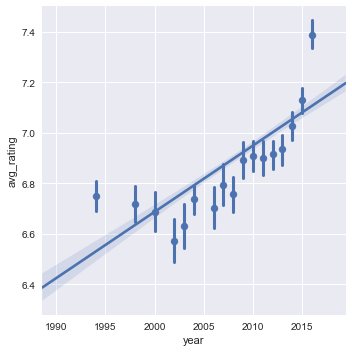

In [11]:
# We should also check to see if the age of the game affects the rating
RatingVis4 = sns.lmplot(data=BoardGamesClean,x='year',y='avg_rating',x_bins=25)

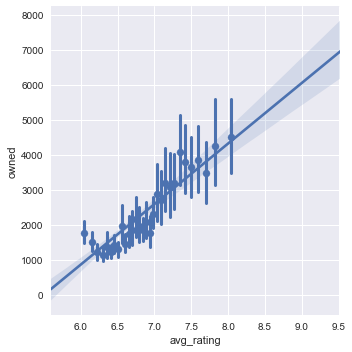

In [12]:
# Finally just to confirm what we would expect are the highly rated games purchased more often?
RatingVis5 = sns.lmplot(data=BoardGamesClean,x='avg_rating',y='owned',x_bins=30,)

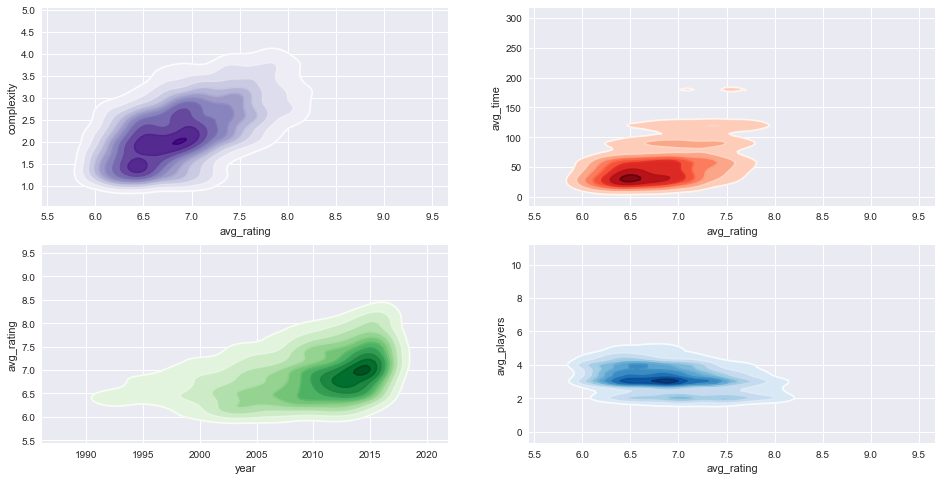

In [56]:
# we can do a density map of these 4 relationships to see where the greatest density is among games in this set
f, axes = plt.subplots(2,2, figsize=(16,8))
RV2b = sns.kdeplot(BoardGamesClean.avg_rating, BoardGamesClean.complexity, shade=True,\
                shade_lowest=False, cmap="Purples",ax=axes[0,0])
RV2c = sns.kdeplot(BoardGamesClean.avg_rating, BoardGamesClean.complexity, cmap="Purples",ax=axes[0,0])
RV3b = sns.kdeplot(BoardGamesClean.avg_rating, BoardGamesClean.avg_time, shade=True,\
                shade_lowest=False, cmap="Reds",ax=axes[0,1])
RV3c = sns.kdeplot(BoardGamesClean.avg_rating, BoardGamesClean.avg_time, cmap="Reds",ax=axes[0,1])
RV4b = sns.kdeplot(BoardGamesClean.year, BoardGamesClean.avg_rating, shade=True,\
                shade_lowest=False, cmap="Greens",ax=axes[1,0])
RV4c = sns.kdeplot(BoardGamesClean.year, BoardGamesClean.avg_rating, cmap="Greens",ax=axes[1,0])
RV5b = sns.kdeplot(BoardGamesClean.avg_rating, BoardGamesClean.avg_players, shade=True,\
                shade_lowest=False, cmap="Blues",ax=axes[1,1])
RV5c = sns.kdeplot(BoardGamesClean.avg_rating, BoardGamesClean.avg_players, cmap="Blues",ax=axes[1,1])



User ratings correlate very closely with the complexity of the game and average amount of time needed to play. The more rules a game has and the longer it takes to play the higher users seem to rate it, but looking at our kernel density function we can clearly see that the majority of the games are at a lower complexity rating, so while highly complex games have higher ratings there are far fewer of them.

This could be due to only serious board game enthusists taking on the more difficult games and more difficult games typically taking longer to play. We can look at the number of reviews versus complexity to see if the most complex games are benefitting from a smaller more dedicated audience. (we will look at this before moving on to the next section).

We see a negative correlation with the number of players which means that the more people needed to play the game the lower the user rating typically is. Games that average between 2 and 3 players had the highest overall ratings, and our density plot shows that the vast majority of games fall in this region.  

Finally, and not surprisingly, the higher rated games are owned by more people than the lower rated games on average.

One intersting thing to note is that the newer games generally have higher ratings than older games. This may be due to improvements in table top game design or the subset of users from Board Game Geek that review games prefering more modern games. 


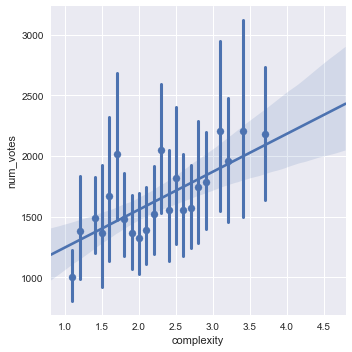

In [14]:
# to confirm our conclusions about rating we should make sure all games are reviewed evenly
RatingVis6 = sns.lmplot(data=BoardGamesClean,x='complexity',y='num_votes',x_bins=25)

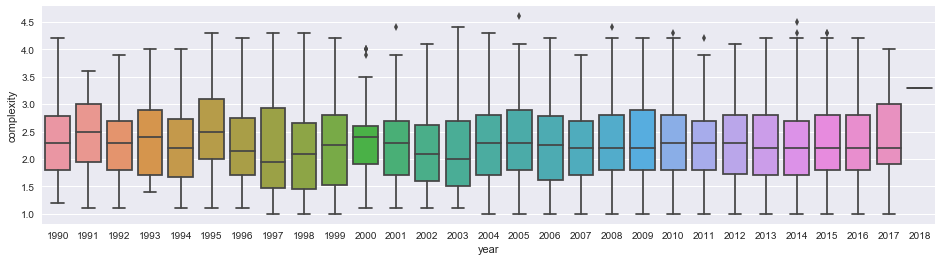

In [15]:
# We can look at the average complexity versus year to make sure games aren't getting more complicated over time
RatingVis6 = sns.boxplot(data=BoardGamesClean,x='year',y='complexity')


It doesnt seem like theres a strong correlation between complexity and the amount of people who review a game so we can assume the reviews are equally weighted for all complexities. This means that users from BGG really do prefer more complex games. 

Also the average complexity of games over time, while variable from year to year, isn't following a specific trend so we can assume that the newer games being rated better is because they are better games and not because they have suddenly become more complex. 

Next we can move on to our second objective:

Lets see if we can determine which factors actually influence whether people buy a game.

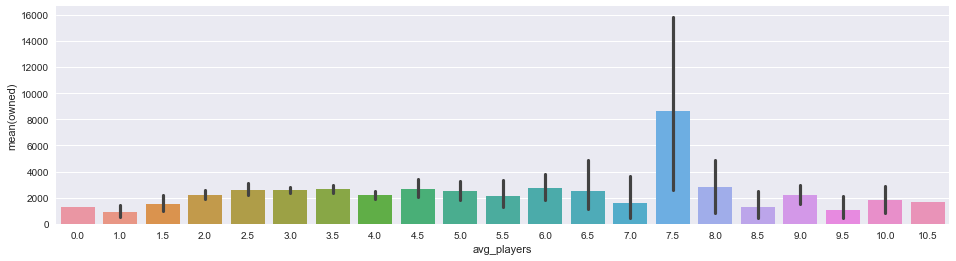

In [16]:
# First lets look at whether the number of players greatly affects how many people own a game
ownedVis1 = sns.barplot(data=BoardGamesClean,x='avg_players',y='owned',)

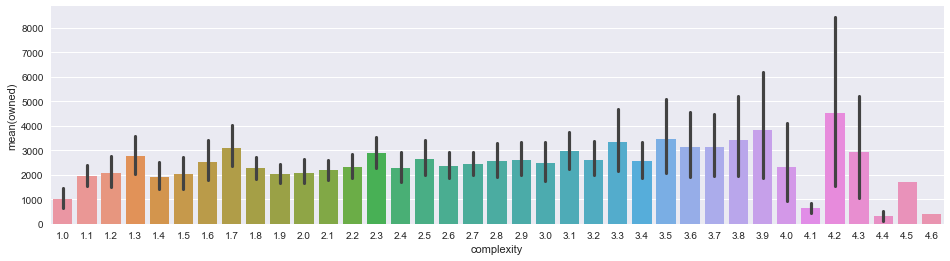

In [17]:
# Next lets see if people are more likely to own games with a certain complexity
ownedVis2 = sns.barplot(data=BoardGamesClean,x='complexity',y='owned',)

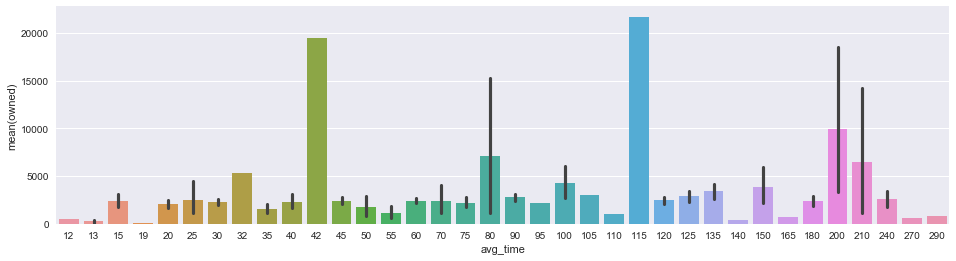

In [18]:
# We can also look at average time and see if people are more likely 
# to own long games or short games
ownedVis2 = sns.barplot(data=BoardGamesClean,x='avg_time',y='owned')

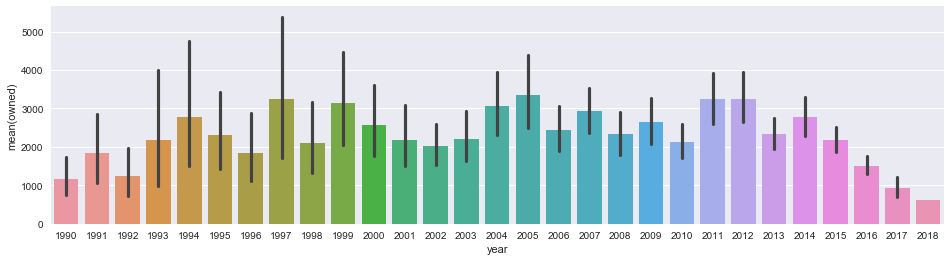

In [19]:
# Now lets see if people on the site own mostly new games or old games.
ownedVis3 = sns.barplot(data=BoardGamesClean,x='year',y='owned',)

---

Not surprisingly there is a correlation between rating and number of people who own the game. People would obviously be more inclined to spend their money on games that are rated highly. 


It doesn't appear that any given number of players, play time, or complexity has a distinct advantage when it comes to getting people to buy a table top game. 

It appears that the only surefire way to make sure you people buy your game is to create a game that will be rated highly. 


---

Now that we have looked at board game landscape as a whole lets move on to our third objective:

Lets explore the top 100 rated games in our cleaned set and see what qualities we should focus on if we want to create a successful boardgame. 

In [21]:
# As the data is listed by rating we can simply slice off the top 100 rows of our cleaned data set (ratings go to 106).
TopGames = BoardGamesClean[0:100]

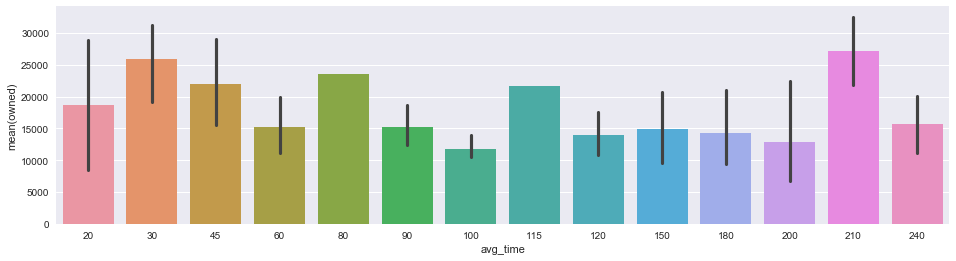

In [22]:
# Lets looks at which qualities correlate to games people actually own
BGTop1 = sns.barplot(data=TopGames,x='avg_time',y='owned',)


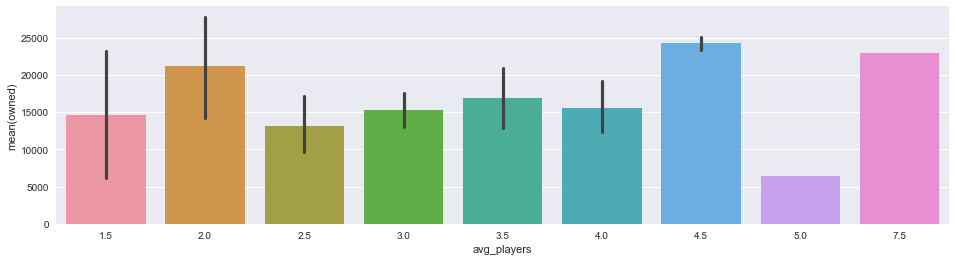

In [23]:
BGTop2 = sns.barplot(data=TopGames,x='avg_players',y='owned',)

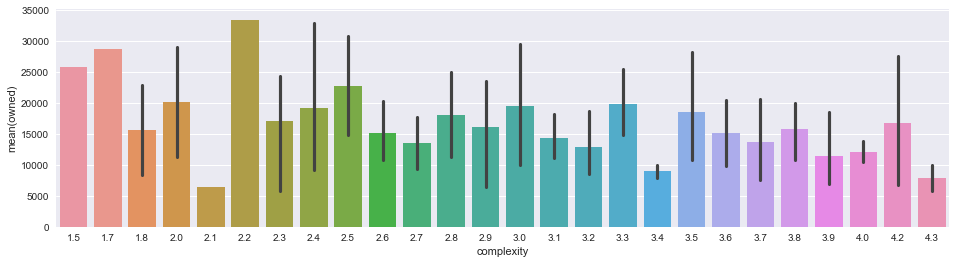

In [24]:
BGTop3 = sns.barplot(data=TopGames,x='complexity',y='owned',)

Despite the fact that overall higher complexity games get higher ratings it seems that low complexity games that take a shorter average time to play and an average of 5 players are the highest owned games from our top 100. So while people may enjoy complex games overall in the top 100 complexity isn't as important. We can look at our plot of complexity versus average rating again just for the top 100 and see how the trend has changed.

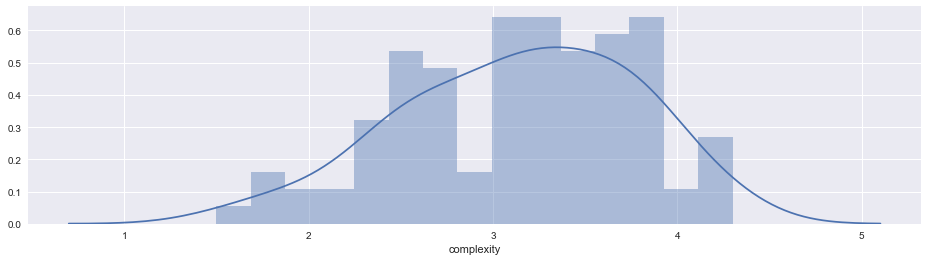

In [25]:
# Lets look at how our top 100 games are distributed based on complexity
BGTop4a = sns.distplot(TopGames.complexity,bins=15)

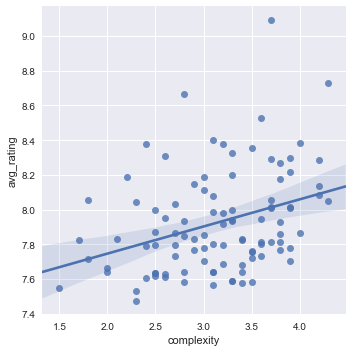

In [26]:
# Most of our top 100 are betwen 3 and 4 for complexity lets see if the correlation with ratings is still strong
BGTop4 = sns.lmplot(data=TopGames,x='complexity',y='avg_rating')

Even for the top 100 games higher complexity generally leads to a higher rating although with a weaker correlation then the data set for all games. Now that we've determined what characterisitics we want to aim for when creating a game in order to make it desirable for people to own (short play time, average of 5 players, low complexity) can we determine that themes are most interesting to potential buyers?

In [27]:
# First we'll create a function that breaks apart each individual category associated with 
# the top 100 games and counts how many times each category word appears.
CatDict = {}
def CatScan(data, row):
    Cats = data.category[row].split(",")
    for term in Cats:
        if term in CatDict.keys():
             CatDict[term] = CatDict[term] + 1
        elif term not in CatDict.keys():
            CatDict[term] = 1

# We can do the same for the mechanics column
MechDict = {}
def MechScan(data, row):
    Mechs = data.mechanic[row].split(",")
    for term in Mechs:
        if term in MechDict.keys():
             MechDict[term] = MechDict[term] + 1
        elif term not in MechDict.keys():
            MechDict[term] = 1

In [28]:
# We can create a dictionary that stores the information about how many times each theme appears 
# in our categories column
CatDict = {}
for row in range(len(TopGames)):
    CatScan(TopGames, row)


In [29]:
# We can repeat this process for game mechanics
MechDict = {}
for row in range(len(TopGames)):
    MechScan(TopGames, row)


In [30]:
# lets turn our new dictionaries into a dataframe so we can visualize the results
themes = pd.DataFrame(list(CatDict.items()), columns=['theme', 'occurance'])
mechanics = pd.DataFrame(list(MechDict.items()), columns=['mechanic', 'occurance'])

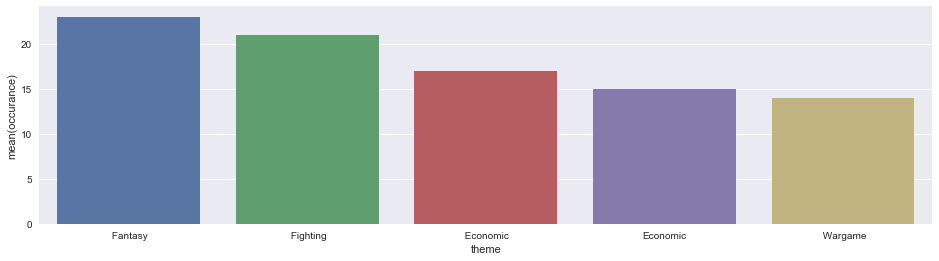

In [31]:
# We can make a bar graph showing the top 5 themes for table top games (from top 100)
themes = themes.sort_values('occurance', ascending=False)
themesVis = sns.barplot(data=themes[0:5],x='theme',y='occurance',)

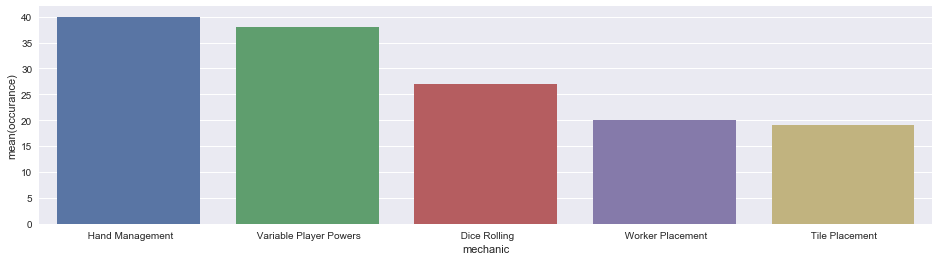

In [32]:
# We can make a bar graph showing the top 5 mechanics for table top games (from the top 100)
mechanics = mechanics.sort_values('occurance', ascending=False)
mechanicsVis = sns.barplot(data=mechanics[0:5],x='mechanic',y='occurance',) 

So it seems from our analysis of themes and mechanics the most popular games have economic, fantasy, and fighting themes and use some sort of hand management and variable player powers mechanics. 

If we combine this with the results from our previous analysis we can determine that if we are trying to make a highly rated game we want to make a complex game that requires 2 to 4 players.

We could redo our top games analysis while sorting out original dataframe by the owned column in order to find which properties are most important for the most highly owned games instead of the top rated games if we were more interested in developing a game appeals to a larger audience. 

Now for our final objective:

Lets try a linear regression to determine the average rating from the complexity.

In [33]:
# Lets create our independent and dependent variables
independent_var = BoardGamesClean["complexity"]


dependent_var = BoardGamesClean['avg_rating']


In [34]:
# Now lets split our data in a test set and train set and scale our data
from sklearn.model_selection import train_test_split
independent_train, independent_test, dependent_train, dependent_test =train_test_split(independent_var, dependent_var, test_size=0.25)

#from sklearn.preprocessing import StandardScaler
#sc_independent = StandardScaler()
#independent_train = sc_independent.fit_transform(independent_train)
#independent_test = sc_independent.transform(independent_test)



In [35]:
# now we create a linear regression from our training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(independent_train, dependent_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [36]:
# Lets predict our test set results
dependent_pred =regressor.predict(independent_test)

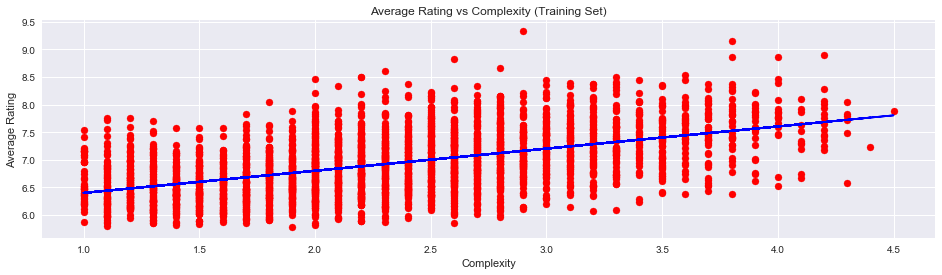

In [37]:
# Now we can visualize how well complexity allows us to predict the average rating
plt.scatter(x=independent_train,y=dependent_train, color='red')
plt.plot(independent_train, regressor.predict(independent_train), color = 'blue')
plt.title('Average Rating vs Complexity (Training Set)')
plt.xlabel('Complexity')
plt.ylabel('Average Rating')
plt.show()

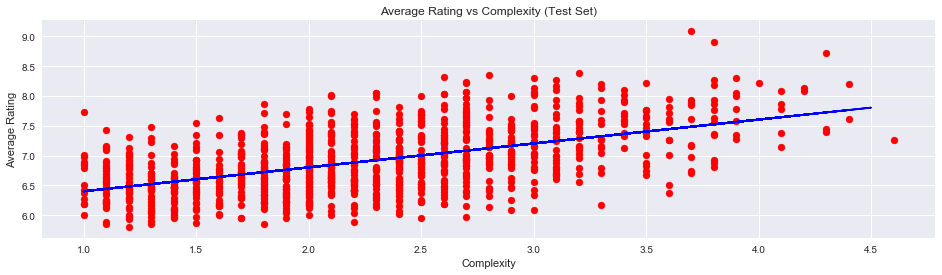

In [38]:
# Now we can visualize how well complexity allows us to predict the average rating
plt.scatter(x=independent_test,y=dependent_test, color='red')
plt.plot(independent_train, regressor.predict(independent_train), color = 'blue')
plt.title('Average Rating vs Complexity (Test Set)')
plt.xlabel('Complexity')
plt.ylabel('Average Rating')
plt.show()

For our linear regression that relies only on complexity the model does follow the trend that higher complexity leads to higher average ratings, but the spread in our data means that for a specific complexity the model does not give an accurate value for average rating.

We can try to increase the number of independent variables to increase the accuracy of our model. Lets inclued the average number of players and the average time played and see if that makes our model better.

In [39]:
independent_var = pd.DataFrame({'complexity':BoardGamesClean["complexity"], "avg_time":BoardGamesClean["avg_time"], "avg_players":BoardGamesClean["avg_players"]})

dependent_var = BoardGamesClean['avg_rating']

In [40]:
from sklearn.model_selection import train_test_split
independent_train, independent_test, dependent_train, dependent_test =train_test_split(independent_var, dependent_var, test_size=0.25)

In [41]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(independent_train, dependent_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [42]:
# Predicting the Test Set results
dependent_pred =regressor.predict(independent_test)

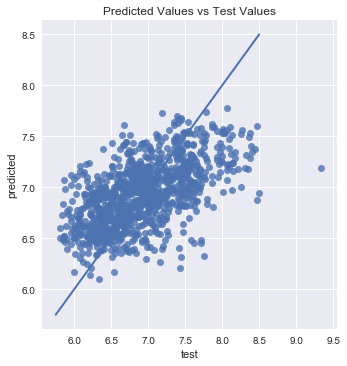

In [53]:

MVReg = pd.DataFrame({'predicted':dependent_pred, 'test':dependent_test})
MVRVis1 = sns.lmplot(data=MVReg, x='test', y='predicted',fit_reg=False,)
plt.plot([5.75, 8.5], [5.75, 8.5], linewidth=2)
plt.title('Predicted Values vs Test Values')

In [44]:
# Lets do backward elimination of our variables to make sure our model is optimal
import statsmodels.formula.api as sm
independent_var = np.append(arr = np.ones((4064,1)).astype(int),values = independent_var, axis=1)
indep_opt = independent_var[:, [0, 1, 2, 3]]
regressor_OLS = sm.OLS(endog = dependent_var, exog = indep_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             avg_rating   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     592.3
Date:                Sun, 15 Oct 2017   Prob (F-statistic):          2.64e-319
Time:                        21:08:53   Log-Likelihood:                -2626.6
No. Observations:                4064   AIC:                             5261.
Df Residuals:                    4060   BIC:                             5286.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.2730      0.038    163.118      0.000       6.198       6.348
x1            -0.0596      0.007     -9.060      0.000      -0.073      -0.047
x2             0.0006      0.000      2.983      0.003       0.000       0.001
x3             0.3506      0.014     24.228      0.000       0.322       0.379
==============================================================================
Omnibus:                       62.597   Durbin-Watson:                   1.648
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.178
Skew:                           0.309   Prob(JB):                     7.03e-15
Kurtosis:                       3.049   Cond. No.                         495.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The P values for each of our independent variables are all less than 0.05, which means that each of them is a useful predictor of average rating. This tells me this model is the best we can do with the data that we have in this set. We can see from our multivariable model that the greatest density of points in our test group do fall near the diagonal which is where our predicted value equals our test value. 

Overall our model could benefit from more variables that can affect the enjoyment of a game such as a rating of the visual elements (high quality card images, figurines and other asthetics). 

I hope you enjoyed exploring this dataset from BoardGameGeek with me!